
# Target/instruments basic use

This notebook shows how to make a single simple experiment 

1. Loading a pre-existing model in Modelflow
2. Creating an experimet by updating some variables
3. Simulating the model
4. Visualizing the results 

This Notebook uses a  model for Pakistan described here: {cite:author}`Burns2021`

In [40]:
%matplotlib inline

## Imports

Modelflow's modelclass includes most of the methods needed to manage a model in Modelflow.

In [41]:
# HIDDEN in jupyterbook 
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')
  incolab = True  
else:
  incolab = False 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from modelclass import model 

model.widescreen()
model.scroll_off()

## Load a  model, data and descriptions 
The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions. The file has been created when onboarding the model. 
Examples can be found [here](../../onboard/eviews/onboard%20one%20model%20from%20%20wf1.html#onboard-a-model-defined-in-a-wf1-file)

In [65]:
mpak,initial = model.modelload('../models/pak.pcim')

file read:  C:\modelflow manual\papers\mfbook\content\models\pak.pcim


In [66]:
baseline = mpak(initial,2022,2100,alfa=0.7,silent=1,ljit=True,stringjit=False)
mpak.basedf = baseline.copy()

Compile prolog: 100%|███████████████████████████████████████████████████████████████████████████| 1/1  2.89s/code chunk
Compile core  : 100%|███████████████████████████████████████████████████████████████████████████| 4/4  2.16s/code chunk
Compile epilog: 100%|███████████████████████████████████████████████████████████████████████████| 9/9  1.85s/code chunk



## One target one instrument with 3 instrument variables

### Define targets and instruments
In year 2100 we want to reduce the emission **PAKCCEMISCO2TKN** to a percent of the baseline (business as usual)

There is a tax rate for 3 different emission fuel types: 

In [67]:
mpak['PAKGGREVCO2?ER'].des

PAKGGREVCO2CER : Carbon tax on coal (USD/t)
PAKGGREVCO2GER : Carbon tax on gas (USD/t)
PAKGGREVCO2OER : Carbon tax on oil (USD/t)


So the tax instrument consists of 3 variables.  The target consist of 1 variable. 

There is one instrument and one target. Which is a necessary condition for solving the problem. 

In [68]:
target_var = ['PAKCCEMISCO2TKN']
instruments = [['PAKGGREVCO2CER','PAKGGREVCO2GER', 'PAKGGREVCO2OER']]

### The  target trajectory. 
In order to solve the target/instrument (aka. goal seeking) problem a dataframe should be constructed with desired values for the target variable(s) 

In [69]:
reduction_percent = 30   # Input the desired reduction in percent. 

The goal is first til find the target emission in 2100 = $PAKCCEMISCO2TKN_{2100} (1-reduction\_percent/100)$ 

Then we want to find the 
target growth rate:  $\dfrac{Target_{2100}}{PAKCCEMISCO2TKN_{2022}}^{\frac{1}{2100-2200}}-1$

With this growth rate emission emission in 2100 will have the desired reduction

In pandas speak this is done in the code below. 

In [70]:
bau_2100        = baseline.loc[2100,'PAKCCEMISCO2TKN']
bau_2022        = baseline.loc[2022,'PAKCCEMISCO2TKN']

target_2100 = baseline.loc[2100,'PAKCCEMISCO2TKN']*(1-reduction_percent/100)
target_growth_rate = (target_2100/bau_2022)**(1/(2100-2022))-1

bau_growth_rate = (bau_2100/bau_2022)**(1/(2100-2022))-1

print(f"Business as usual Emission value in 2100: {bau_2100:13,.0f}")
print(f"Business as usual Emission value in 2100: {target_2100:13,.0f}")
print(f"Business as usual growth rate in percent: {bau_growth_rate:13,.1%}")
print(f"Target growth rate in percent           : {target_growth_rate:13,.1%}")

Business as usual Emission value in 2100: 1,950,344,715
Business as usual Emission value in 2100: 1,365,241,301
Business as usual growth rate in percent:          2.8%
Target growth rate in percent           :          2.4%


### Create a dataframe with the target 
Now a dataframe can be created using the growth rate for the target variable calculated above. 

The dataframe should only contain columns for the target variables - here only one. 

In [71]:
target_before = baseline.loc[2022:,['PAKCCEMISCO2TKN']]     # Create dataframe with only the target variable 
# create a target dataframe with a projection of the target variable 
target = target_before.upd(f'<2023 2100> PAKCCEMISCO2TKN =growth {100*target_growth_rate}')

### Now solve the problem: 

Now we have a dataframe with target values and a list of instrument variables. We are ready to solve the problem. 

In [72]:
%%time
_ = mpak.invert(baseline,                  # Invert calls the target instrument device                   
                targets = target,                   
                instruments=instruments,
                DefaultImpuls=2,              # The default impulse instrument variables 
                defaultconv=2.0,              # Convergergence criteria for targets
                varimpulse=False,             # Changes in instruments in each iteration are carried over to the future
                nonlin=15,                    # If no convergence in 15 iteration recalculate jacobi 
                silent=1,                     # Don't show iteration output (try 1 for showing)
                delay=0,
               )

Finding instruments :   0%|          | 0/79

CPU times: total: 4.55 s
Wall time: 6.6 s


### Make a graph and decorate with a line and an annotation
Also show the tax rate



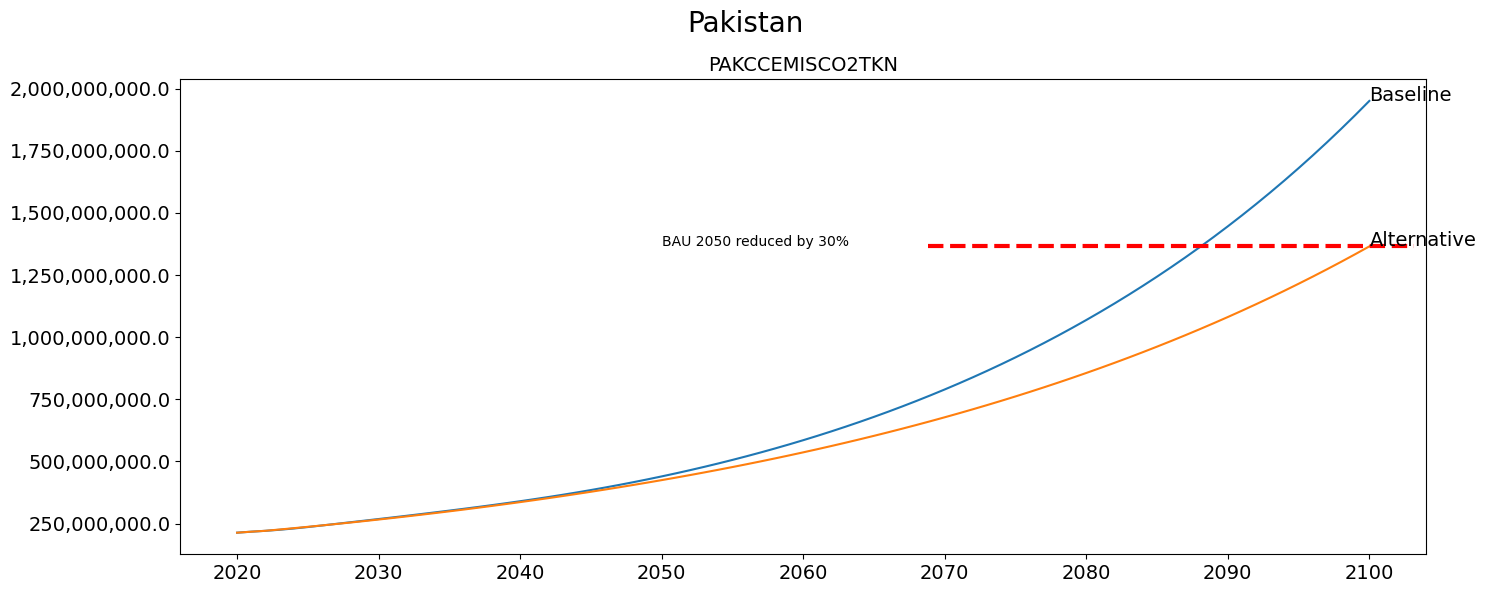

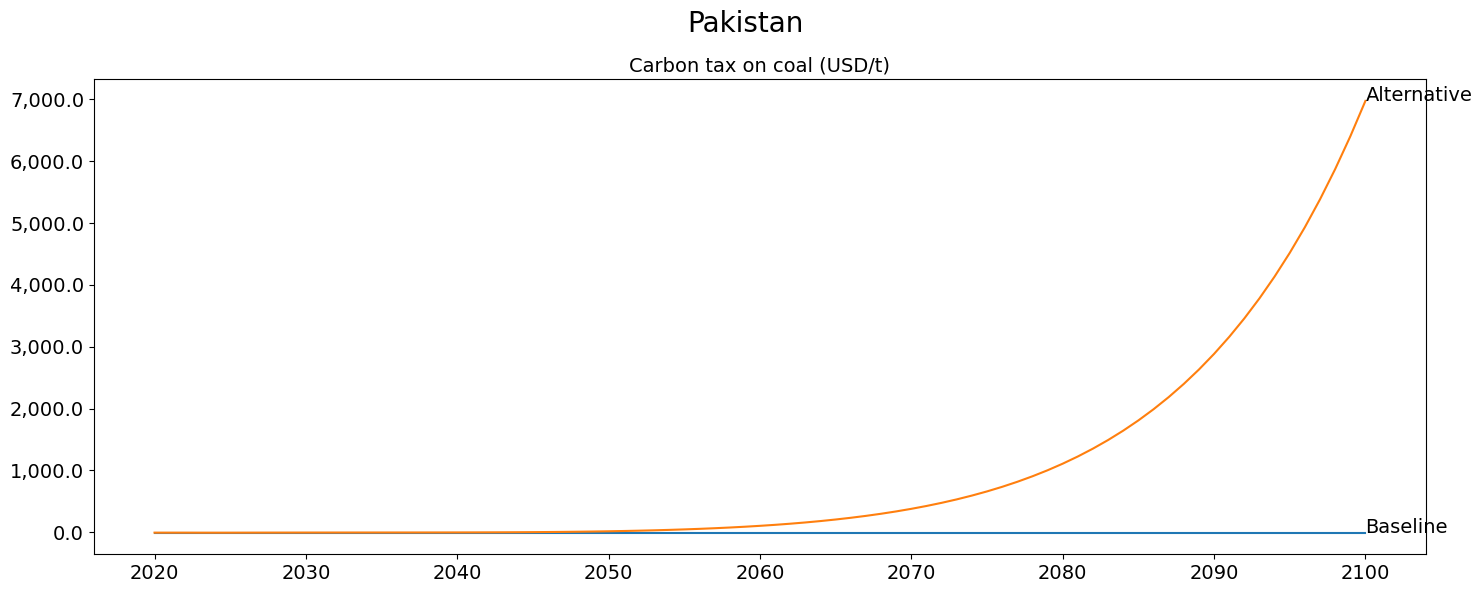

In [73]:
with mpak.set_smpl(2020,2100):    # change if you want another  timeframe 
    fig = mpak[f'PAKCCEMISCO2TKN' ].plot_alt(title='Pakistan')
    fig.axes[0].axhline( target_2100,
                                  xmin=0.6,
                                  xmax = 0.99,
                                  linewidth=3, 
                                  color='r', ls='dashed')

    fig.axes[0].annotate(f'BAU 2050 reduced by {reduction_percent}%', xy=(2050,target_2100 ))
    fig2 = mpak[f'PAKGGREVCO2CER' ].plot_alt(title=f'Pakistan'); 


### Look at selected variables with the [] operator 
If you want to look at multiple variables the index [] operator can be used to select the variables to analyze/visualize. Here only a few operations will be shown. There is more [here](index-operator)

In [74]:
mpak['PAKNYGDPMKTPKN PAKNECONGOVTKN PAKNEGDIFTOTKN PAKNEIMPGNFSKN PAKCCEMISCO2TKN']

## Now define instruments so they don't get the same shock. 
Here the coal emission gets twice the shock as the two other. 

In [75]:
new_instruments =[[('PAKGGREVCO2CER',10),
                   ('PAKGGREVCO2GER', 5),
                   ('PAKGGREVCO2OER',5)]]


_ = mpak.invert(baseline,targets = target,
                            instruments=new_instruments,
                          DefaultImpuls=1,
                                defaultconv=2.0,varimpulse=True,nonlin=15,silent=1)

Finding instruments :   0%|          | 0/79

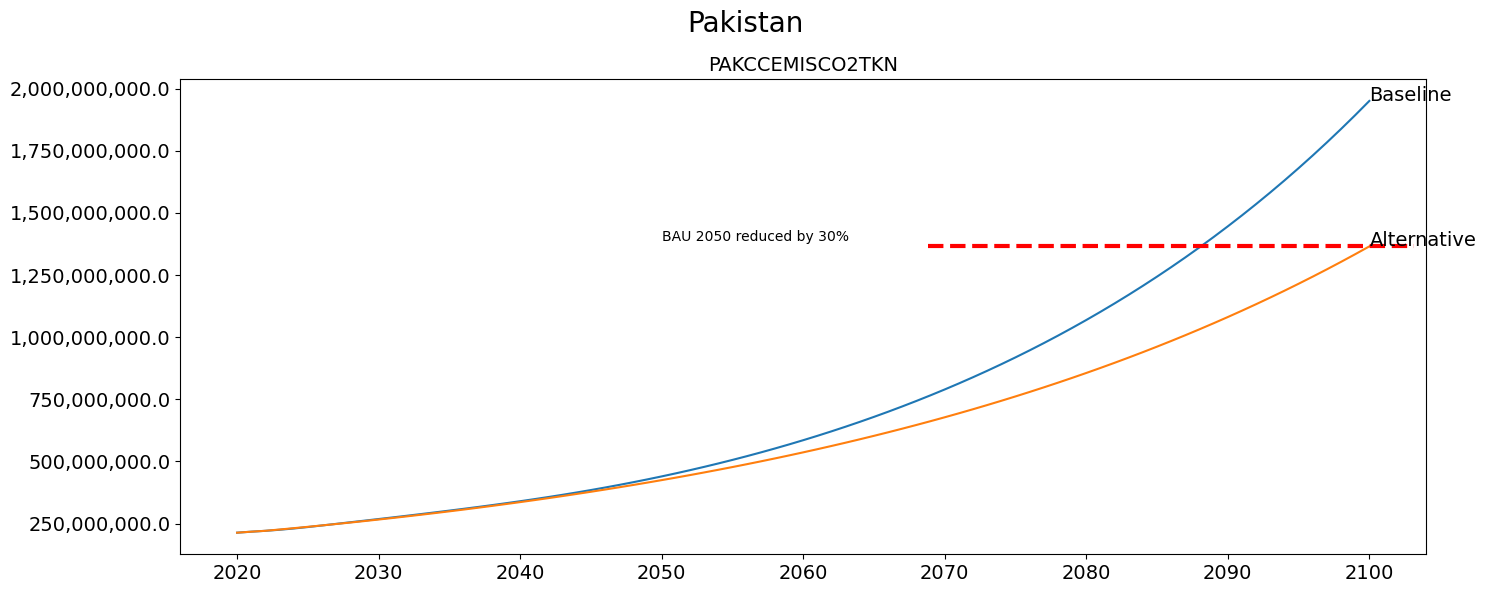

In [76]:
with mpak.set_smpl(2020,2100):    # change if you want another  timeframe 
    fig = mpak[f'PAKCCEMISCO2TKN' ].plot_alt(title='Pakistan')
    fig.axes[0].axhline( target_2100,
                                  xmin=0.6,
                                  xmax = 0.99,
                                  linewidth=3, 
                                  color='r', ls='dashed')

    fig.axes[0].annotate(f'BAU 2050 reduced by {reduction_percent}%', xy=(2050,target_2100*1.015 ))

When the instrument values are inspected the differences reflect the size of the impulse used. 

In [77]:
    mpak['PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER PAKGGBALOVRLCN' ]

In [78]:

mpak['PAKGGBALOVRLCN'].des

PAKGGBALOVRLCN : General Government Revenue, Deficit, LCU mn


In [79]:
mpak['pakggexpcap*'].endo

### Now target two variables


In [80]:
# next 
# target PAKGGBALOVRLCN so the revenue is used 
# instrument 

In [81]:
target_2 = target.copy() 
target_2.loc[:,'PAKGGBALOVRLCN'] = baseline.loc[2022:2100,'PAKGGBALOVRLCN']

In [82]:
target_2

,PAKCCEMISCO2TKN,PAKGGBALOVRLCN
2022,2.210725e+08,-1.939507e+06
2023,2.262932e+08,-2.033015e+06
2024,2.316372e+08,-2.146245e+06
2025,2.371075e+08,-2.279101e+06
2026,2.427069e+08,-2.433659e+06
...,...,...
2096,1.243546e+09,-7.546307e+08
2097,1.272913e+09,-8.227378e+08
2098,1.302974e+09,-8.969610e+08
2099,1.333744e+09,-9.778463e+08


In [83]:
instruments_2 = instruments + ['PAKGGEXPCAPTCN_A']
instruments_2

[['PAKGGREVCO2CER', 'PAKGGREVCO2GER', 'PAKGGREVCO2OER'], 'PAKGGEXPCAPTCN_A']

In [84]:
_ = mpak.invert(baseline,                  # Invert calls the target instrument device                   
                targets = target_2,                   
                instruments=instruments_2,
                DefaultImpuls=2,              # The default impulse instrument variables 
                defaultconv=2.0,              # Convergergence criteria for targets
                varimpulse=False,             # Changes in instruments in each iteration are carried over to the future
                nonlin=15,                    # If no convergence in 15 iteration recalculate jacobi 
                silent=1,                     # Don't show iteration output (try 1 for showing)
                delay=0,debug=0
               )

Finding instruments :   0%|          | 0/79

In [85]:
    mpak['PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER PAKGGBALOVRLCN' ]

In [86]:
(mpak.lastdf.loc[2022:2035,'PAKGGBALOVRLCN']-mpak.basedf.loc[2022:2035,'PAKGGBALOVRLCN'])

2022    0.001890
2023   -0.028246
2024   -0.006773
2025    0.008207
2026    0.002587
2027    0.002268
2028    0.005406
2029    0.003312
2030    0.002225
2031    0.004338
2032    0.003260
2033    0.002529
2034    0.002108
2035    0.003929
Name: PAKGGBALOVRLCN, dtype: float64